In [167]:
import os;
import json;
import builtins
import pandas as pd;

dir = '/home/chesetti/Repos/learned_merge_cleanup/sponge'
testcase = 'join_comp/join_fb_1'
test_dir = os.path.join(dir, testcase)
results_dir = os.path.join(test_dir, 'outputs', 'results')
csv_dir = os.path.join(test_dir, 'csv')
os.makedirs(csv_dir, exist_ok=True)

runs = [os.path.join(results_dir, run) for run in os.listdir(results_dir)]
print(runs)

['/home/chesetti/Repos/learned_merge_cleanup/sponge/join_comp/join_fb_1/outputs/results/run']


In [168]:
# Walk all the json files and put them in a dataframe

test_results = []
for run in runs:
    for test_result_file in os.listdir(run):
        json_file = builtins.open(os.path.join(run, test_result_file))
        test_result = json.load(json_file)
        test_result['run'] = run
        test_results.append(test_result)
        json_file.close()
test_dataframe = pd.json_normalize(test_results)
print(test_dataframe.columns)

        

Index(['command', 'run', 'result.checksum', 'result.duration_ns',
       'result.duration_sec', 'result.inner_disk_fetch',
       'result.inner_disk_fetch_size', 'result.inner_total_bytes_fetched',
       'result.outer_disk_fetch', 'result.outer_disk_fetch_size',
       'result.outer_total_bytes_fetched', 'spec.algo', 'spec.algo_name',
       'spec.check_checksum', 'spec.common_key',
       'spec.index.leaf_size_in_pages', 'spec.index.search', 'spec.index.type',
       'spec.inner_table', 'spec.key_size', 'spec.key_type',
       'spec.load_sstable_in_mem', 'spec.name', 'spec.num_threads',
       'spec.outer_table', 'spec.result_path', 'spec.value_size',
       'spec.write_result_to_disk'],
      dtype='object')


# Reports

### Overall Duration

Index(['btree2048', 'flatpgm2048', 'flatpgm256', 'hj', 'inljBtree2048',
       'inljBtree256', 'inljPgm256', 'sj'],
      dtype='object', name='spec.algo_name')
Index([1, 5, 10, 50, 100, 500, 1000], dtype='int64', name='spec.common_key')
spec.algo_name             hj            sj  inljBtree256    inljPgm256  \
spec.common_key                                                           
1                4.648467e+09  1.170565e+09  3.720930e+09  2.777466e+09   
5                3.564266e+09  4.895646e+08  9.145313e+08  7.139148e+08   
10               3.070504e+09  4.860355e+08  5.199278e+08  5.348501e+08   
50               1.453541e+09  2.963216e+08  1.719724e+08  1.501324e+08   
100              1.357596e+09  2.866109e+08  1.289180e+08  1.102106e+08   
500              1.369988e+09  2.716499e+08  5.774101e+07  5.745903e+07   
1000             1.143628e+09  2.693897e+08  4.094685e+07  4.113663e+07   

spec.algo_name    flatpgm2048     btree2048    flatpgm256  
spec.common_key           

'\nfor column in throughput.columns:\n    throughput[column] = (200_000_000/throughput.index) * (1000_000_000.0 / throughput[column])\n    throughput[column +"_sj-rel"] = (throughput[column] - throughput["sj"] / throughput["sj"]) * 100.0\nprint(throughput)\noverall_duration[["btree2048", "btree1024", "btree256", "sj"]].plot() \noverall_duration[["pgm128", "pgm512", "pgm1024", "sj"]].plot() \n'

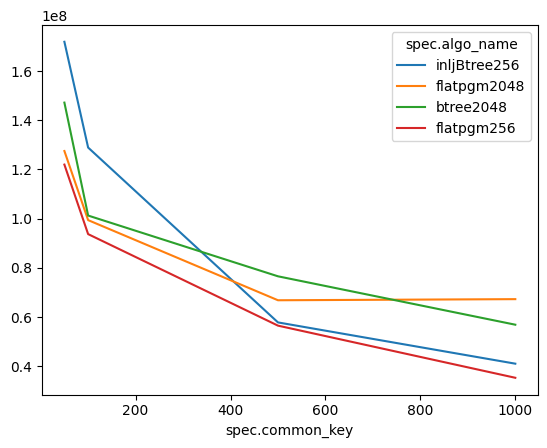

In [177]:
overall_duration = test_dataframe.pivot_table(index='spec.common_key', columns='spec.algo_name', values='result.duration_ns', aggfunc='median')
overall_duration.to_csv(os.path.join(csv_dir, 'duration_sec.csv'))
print(overall_duration.columns)
print(overall_duration.index)
throughput = overall_duration
print(throughput[["hj", "sj", "inljBtree256", "inljPgm256", "flatpgm2048", "btree2048", "flatpgm256"]].to_markdown())
throughput[["inljBtree256", "flatpgm2048", "btree2048", "flatpgm256"]].loc[throughput.index > 10].plot()
'''
for column in throughput.columns:
    throughput[column] = (200_000_000/throughput.index) * (1000_000_000.0 / throughput[column])
    throughput[column +"_sj-rel"] = (throughput[column] - throughput["sj"] / throughput["sj"]) * 100.0
print(throughput)
overall_duration[["btree2048", "btree1024", "btree256", "sj"]].plot() 
overall_duration[["pgm128", "pgm512", "pgm1024", "sj"]].plot() 
'''

In [170]:
inner_index_fetch = test_dataframe.pivot_table(index='spec.common_key', columns='spec.algo_name', values='result.inner_disk_fetch', aggfunc='median')
inner_index_total_fetch = test_dataframe.pivot_table(index='spec.common_key', columns='spec.algo_name', values='result.inner_total_bytes_fetched', aggfunc='median')
inner_index_fetch_size = test_dataframe.pivot_table(index='spec.common_key', columns='spec.algo_name', values='result.inner_disk_fetch_size', aggfunc='median')
print(inner_index_fetch)
print(inner_index_total_fetch)
print(inner_index_fetch_size)

spec.algo_name   btree2048  flatpgm2048  flatpgm256     hj  inljBtree2048  \
spec.common_key                                                             
1                     9293         8261       37172  74343           9293   
5                     9293         8261       37170  74343           9293   
10                    9293         8261       37164  74343           9293   
50                    9293         8260       36715  74343           9293   
100                   9293         8256       35210  74343           9293   
500                   9152         7963       21702  74343           9152   
1000                  8221         7179       14195  74343           8221   

spec.algo_name   inljBtree256  inljPgm256     sj  
spec.common_key                                   
1                       74343      100658  74343  
5                       74343       98124  74343  
10                      74343       94732  74343  
50                      73966       70149  74343  


In [171]:
result_checksum = (test_dataframe[['spec.common_key', 'spec.algo_name', 'result.checksum']].sort_values(by=['spec.common_key', 'spec.algo_name'])) #.loc[test_dataframe['spec.common_key']=='10'])
for common_key in sorted(test_dataframe['spec.common_key'].unique()):
    checksums = result_checksum.loc[result_checksum['spec.common_key'] == common_key]
    unique_checksums = checksums['result.checksum'].unique()
    if (len(unique_checksums) == 1):
        print(f"common_key: {common_key} checksum: {unique_checksums} OK")
    else:
        print(f"common_key: {common_key} checksums don't match")
print(result_checksum.loc[result_checksum['spec.common_key'] == 100])
print(result_checksum.loc[result_checksum['spec.common_key'] == 100]['result.checksum'].unique())

common_key: 1 checksum: ['64C4DAA1D52A16360322A4026582CC2A'] OK
common_key: 5 checksum: ['AC4078D6A50AB913FCA79DAEB1FED067'] OK
common_key: 10 checksum: ['8C74692D9641D0C1577BF2EF4526F2B8'] OK
common_key: 50 checksum: ['ED4BD5419C1FF8EE3BADE324DC0579E3'] OK
common_key: 100 checksum: ['F14FA0A1E6DF3DDC590BF8454501A8C0'] OK
common_key: 500 checksum: ['672E778F2D95D37E910B77EED3C23E24'] OK
common_key: 1000 checksum: ['57E4752DE6A6349615E6B9205FF525A2'] OK
     spec.common_key spec.algo_name                   result.checksum
43               100      btree2048  F14FA0A1E6DF3DDC590BF8454501A8C0
99               100      btree2048  F14FA0A1E6DF3DDC590BF8454501A8C0
84               100    flatpgm2048  F14FA0A1E6DF3DDC590BF8454501A8C0
101              100    flatpgm2048  F14FA0A1E6DF3DDC590BF8454501A8C0
5                100     flatpgm256  F14FA0A1E6DF3DDC590BF8454501A8C0
66               100     flatpgm256  F14FA0A1E6DF3DDC590BF8454501A8C0
4                100             hj  F14FA0A1E6DF3DDC